In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from utils.pandas import apply_filters
from utils_local import read_spreadsheet, colors_v1, markers_v1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [5]:
def get_xvalues_for_correlation(key="K400-linear", remove_moco=False):
    assert key in ["K400-linear", "UCF101-finetune"]
    xaxis, subkey = key.split("-")

    if xaxis == "K400":
        xvalues = k400_values[subkey]
        xmethods = k400_values["Method"]
        xlabel = "K400 Linear"
    elif xaxis == "UCF101":
        xvalues = ucf101_values[subkey]
        xmethods = ucf101_values["Method"]
        xlabel = "UCF-101 Finetuning"
    else:
        raise ValueError
    
    if remove_moco:
        xmethods = list(xmethods)
        moco_index = xmethods.index("MoCo")
        xmethods = [x for i, x in enumerate(xmethods) if i != moco_index]
        xvalues = [x for i, x in enumerate(xvalues) if i != moco_index]
    
    return xmethods, xvalues, xlabel

### All results w.r.t. Kinetics-400

In [6]:
# load domain-shift results
from utils_local import load_domain_shift_results, scatter_with_correlation

k400_values, df_linear, df_finetune = load_domain_shift_results(remove_K400=True)
ucf101_values = {"Method": list(df_finetune.index), "finetune": df_finetune["UCF101"].values}

In [7]:
# load granularity results

from utils_local import load_finegym_results

df_granularity = load_finegym_results()
# extract per-class results
df_class = df_granularity[[x for x in df_granularity.columns if "class" in x or "Method" in x]]
df_class = df_class.set_index(keys=["Method"])
df_class.columns = [x.replace(" (class)", "") for x in df_class.columns]

In [8]:
# load task-shift results

from utils_local import load_task_shift_results

df_task = load_task_shift_results()

In [9]:
xmethods, xvalues, xlabel = get_xvalues_for_correlation("K400-linear")

In [10]:
df_linear

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,0.00,0.00,0.00,0.00,0.00
MoCo,65.40,29.53,29.66,9.68,21.40
SeLaVi,51.18,15.74,20.23,4.51,22.42
VideoMoCo,66.27,51.58,41.57,19.54,25.67
Pretext-contrast,57.15,17.61,29.98,10.86,20.04
RSPNet,76.63,33.47,32.16,12.52,24.82
AVID-CMA,78.14,53.93,45.12,16.12,22.53
CTP,37.93,22.58,30.62,12.20,20.04
TCLR,63.26,33.45,33.04,10.84,21.82
GDT,75.73,38.21,34.15,11.87,25.34


In [11]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
MoCo,83.80,93.41,83.62,52.42,26.40
SeLaVi,84.88,92.78,88.93,56.37,33.77
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
RSPNet,88.47,93.90,91.28,59.39,42.67
AVID-CMA,89.33,93.99,90.56,53.82,29.91
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.97,36.18
GDT,91.14,93.89,90.36,57.78,37.26


In [12]:
df_class

,Gym99 (99),Gym288 (288),Vault (6),FX (35),FX-S1 (11),UB-S1 (15)
Method,,,,,,
None,84.40,50.01,24.67,75.88,44.98,83.98
MoCo,83.62,51.65,32.10,82.95,62.21,84.14
SeLaVi,84.75,52.82,25.44,76.04,50.15,81.46
VideoMoCo,86.36,54.07,27.78,79.52,60.39,82.07
Pretext-contrast,85.70,52.66,28.48,81.37,65.78,86.24
RSPNet,87.59,55.20,33.35,82.72,63.50,85.12
AVID-CMA,85.83,52.46,30.35,82.65,67.15,88.41
CTP,88.33,56.51,26.83,86.16,79.66,88.44
TCLR,87.97,55.37,29.84,84.25,61.02,85.29


In [13]:
df_task

,UCF - Action recognition (Top-1),UCF - Spatio-temporal (IoU@0.5),UCF - Repetition (1 - MAE),UCF - AoT (Top-1),Charades - Multi-label (mAP),AVA - Spatio-temporal (mAP)
Method,,,,,,
None,75.36,0.3273,0.7680,56.106,7.895,0.000
MoCo,83.80,0.4155,0.7805,54.467,8.134,11.713
VideoMoCo,85.59,0.4374,0.8241,72.905,10.454,13.097
Pretext-contrast,85.83,0.4619,0.8315,77.227,8.930,12.653
SeLaVi,86.60,0.4192,0.8488,77.439,8.218,10.227
RSPNet,88.47,0.4401,0.8400,86.955,9.146,14.057
AVID-CMA,89.33,0.4354,0.8381,83.254,8.350,10.014
TCLR,89.77,0.4764,0.8507,85.633,11.135,10.809
CTP,90.77,0.4646,0.8217,77.055,9.645,10.081


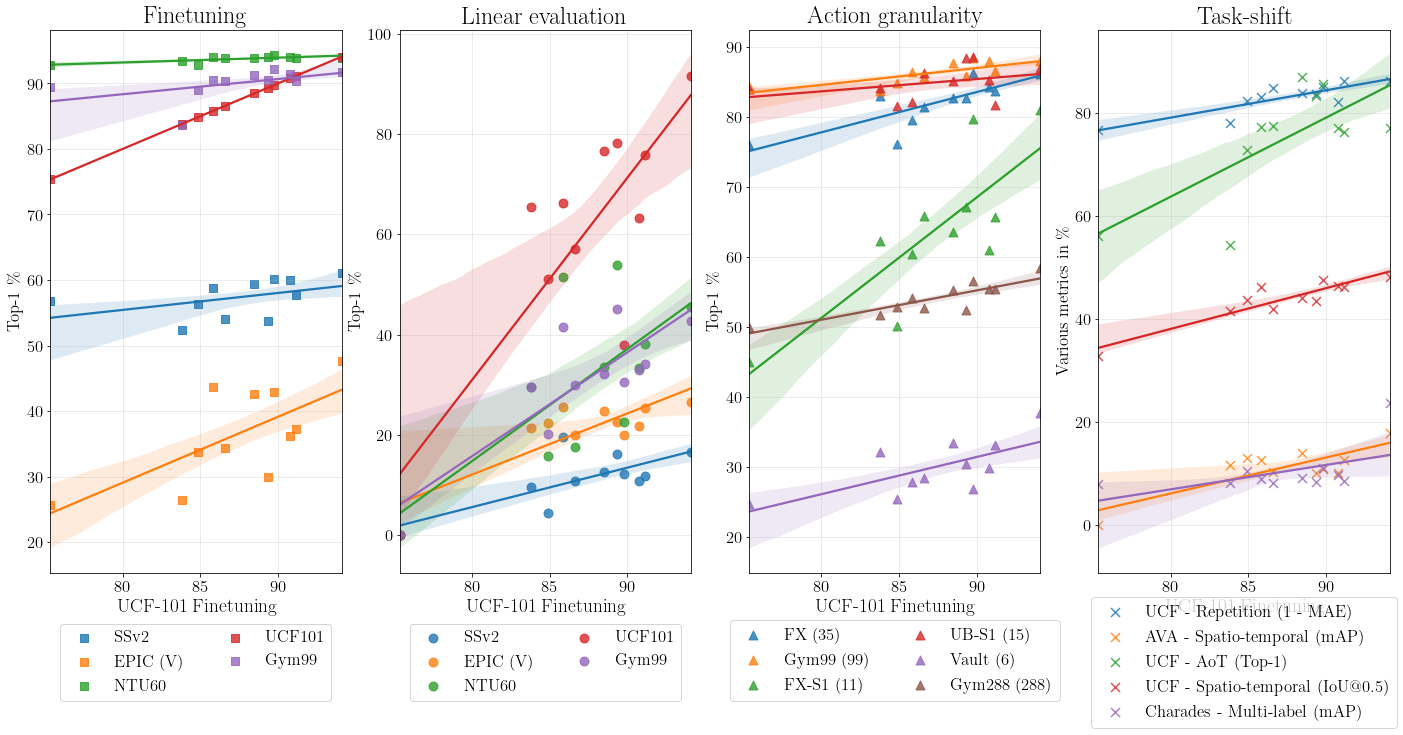

In [14]:
figsize = (24, 10)
nrows, ncols = 1, 4
width_per_ax = figsize[0] // ncols
height_per_ax = figsize[1] // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

subtitlesize = (width_per_ax * height_per_ax) // 2.5
tickssize = 0.7 * subtitlesize
legendsize = 0.7 * subtitlesize
xlabelsize = 0.8 * subtitlesize
ylabelsize = 0.7 * subtitlesize

markersize=80
scatter_kws={'s': markersize}

def regplot_for_df(ax, df, xlabel, ylabel, subtitle, show_xlabel=True, xmargin=0.0, ci=95, marker="o", scatter_kws=scatter_kws):

    for col in set(df.columns) - {xlabel}:
        sns.regplot(data=df, x=xlabel, y=col, label=col, ax=ax, ci=ci, marker=marker, scatter_kws=scatter_kws)
    ax.legend(fontsize=legendsize)
    
    ax.grid(alpha=0.3)
    ax.set_title(subtitle, fontsize=subtitlesize)
    if show_xlabel:
        ax.set_xlabel(xlabel, fontsize=xlabelsize)
    else:
        ax.set_xlabel("")
    ax.set_ylabel(ylabel, fontsize=ylabelsize)
    ax.tick_params(axis='y', which='major', labelsize=tickssize, rotation=0)
    ax.tick_params(axis='x', which='major', labelsize=tickssize, rotation=0)
    ax.margins(x=xmargin)

# key = "K400-linear"
key = "UCF101-finetune"
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key, remove_moco=False)
ci = 80

# plot domain shift for linear evaluation
ax = axes[1]
df = df_linear.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Linear evaluation", ci=ci, marker="o")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot domain shift for finetuning
ax = axes[0]
df = df_finetune.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Finetuning", ci=ci, marker="s")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot granularity shift
ax = axes[2]
df = df_class.copy()
df[xlabel] = xvalues
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Top-1 \\%", subtitle="Action granularity", ci=ci, marker="^")
legend_kwargs = dict(
    ncol=2,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)


# plot task shift
ax = axes[3]
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key, remove_moco=False)
df = df_task.copy()
df[xlabel] = xvalues
normalize = True
if normalize:
    # df = (df - df.min()) / (df.max() - df.min())
    df["UCF - Spatio-temporal (IoU@0.5)"] *= 100.
    df["UCF - Repetition (1 - MAE)"] *= 100.
remove_ucf_action_rec = True
if remove_ucf_action_rec:
    df.drop(columns=["UCF - Action recognition (Top-1)"], inplace=True)
regplot_for_df(ax, df, xlabel=xlabel, ylabel="Various metrics in \\%", subtitle="Task-shift", ci=ci,
               show_xlabel=True, marker="x")
legend_kwargs = dict(
    ncol=1,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.3),
    fontsize=legendsize,
)
ax.legend(**legend_kwargs)

plt.savefig(f"../../results/plots/correlations_all_on_{xlabel}_ci_{ci}.pdf", bbox_inches="tight")
plt.show()

1. ~Use different markers for different subplots~
2. ~Plot with 80% and 95% CI and put them in overleaf (one in appendix)~
3. ~Remove UCF action recognition from Task-shift~
4. ~Add `K400 Linear` for Task shift as well~
5. ~Try adding avg of dataset sizes as 5th subplot in the above plot~
6. ~No need to have domain-shift in titles here~
7. ~Swap orders of Finetune and Linear. Then varying dataset size~


1. Bar-plot for Spearman rank correlations similar to Fig 2 in Edinburgh


1. Dataset size bar plot for

In [15]:
def beautify_ax(
        ax, subtitle="My subplot", subtitlesize=20, xlabel="", xrotation=0,
        ylabel="", yrotation=0, xmargin=0.0, grid_alpha=0.3, ylim=None,
    ):
    
    tickssize = 0.7 * subtitlesize
    legendsize = 0.7 * subtitlesize
    xlabelsize = 0.8 * subtitlesize
    ylabelsize = 0.8 * subtitlesize

    ax.grid(alpha=grid_alpha)
    ax.set_title(subtitle, fontsize=subtitlesize)
    ax.set_xlabel(xlabel, fontsize=xlabelsize)
    ax.set_ylabel(ylabel, fontsize=ylabelsize)

    ax.tick_params(axis='y', which='major', labelsize=tickssize, rotation=yrotation)
    ax.tick_params(axis='x', which='major', labelsize=tickssize, rotation=xrotation)
    ax.margins(x=xmargin)
    
    if ylim is not None:
        ax.set_ylim(ylim)

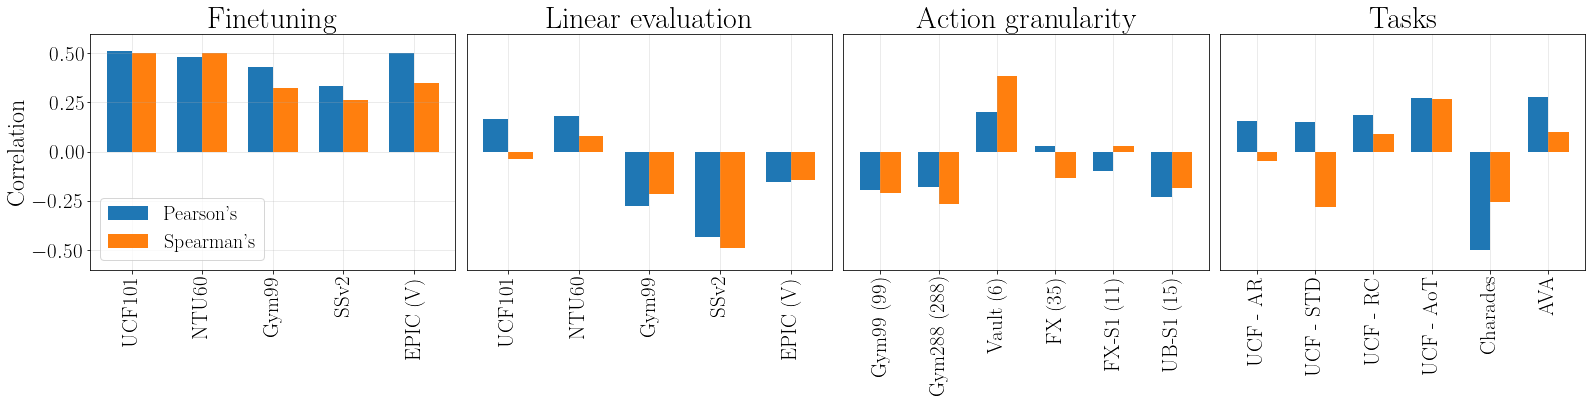

In [16]:
figsize = (22, 5.5)
nrows, ncols = 1, 4
width_per_ax = figsize[0] // ncols
height_per_ax = figsize[1] // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)

subtitlesize = (width_per_ax * height_per_ax) // 2.5
tickssize = 0.7 * subtitlesize
legendsize = 0.7 * subtitlesize
xlabelsize = 0.8 * subtitlesize
ylabelsize = 0.7 * subtitlesize

markersize=80
scatter_kws={'s': markersize}

def barplot_per_ax(ax, df, width=0.35):
    
    corr = df.corr(method="pearson").loc["K400 Linear"].drop("K400 Linear")
    xticks = list(corr.index)
    x = np.arange(len(xticks))
    
    ax.bar(x=x, height=corr.values, width=width, label="Pearson's")
    corr = df.corr(method="spearman").loc["K400 Linear"].drop("K400 Linear")
    ax.bar(x=x + width, height=corr.values, width=width, label="Spearman's")

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(xticks)

ylim=None
ylim = (-0.6, 0.6)
xmargin = 0.05


ax = axes[0]
beautify_ax(ax=ax, subtitle="Finetuning", subtitlesize=30, ylabel="Correlation", xmargin=xmargin, xrotation=90, ylim=ylim)

legendsize = 20

xmethods, xvalues, xlabel = get_xvalues_for_correlation("K400-linear", remove_moco=False)
df = df_linear.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
barplot_per_ax(ax, df)
ax.legend(fontsize=legendsize)

ax = axes[1]
beautify_ax(ax=ax, subtitle="Linear evaluation", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
df = df_finetune.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

ax = axes[2]
beautify_ax(ax=ax, subtitle="Action granularity", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
df = df_class.copy()
df[xlabel] = xvalues
df = df.loc[np.array(xmethods)].reset_index()
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

ax = axes[3]
beautify_ax(ax=ax, subtitle="Tasks", subtitlesize=30, xrotation=90, ylim=ylim, xmargin=xmargin)
xmethods, xvalues, xlabel = get_xvalues_for_correlation("K400-linear", remove_moco=False)
df = df_task.copy()
df = df.loc[np.array(xmethods)]
df[xlabel] = xvalues
df = df.rename(
    columns={
        "UCF - Action recognition (Top-1)": "UCF - AR",
        "UCF - Spatio-temporal (IoU@0.5)": "UCF - STD",
        "UCF - AoT (Top-1)": "UCF - AoT",
        "UCF - Repetition (1 - MAE)": "UCF - RC",
        "Charades - Multi-label (mAP)": "Charades",
        "AVA - Spatio-temporal (mAP)": "AVA",
    },
)
barplot_per_ax(ax, df)
ax.set_yticks([])
# ax.legend(fontsize=legendsize)

plt.savefig(f"../../results/plots/both_correlations_on_{xlabel}_v1.pdf", bbox_inches="tight")
plt.show()

### Heatmaps for task-shift experiments

In [69]:
df_task = load_task_shift_results(complement_repetition=True)

# rename columns
df_task = df_task.rename(
    columns={
        "UCF - Action recognition (Top-1)": "UCF - AR",
        "UCF - Spatio-temporal (IoU@0.5)": "UCF - STD",
        "UCF - AoT (Top-1)": "UCF - AoT",
        "UCF - Repetition (1 - MAE)": "UCF - RC",
        "Charades - Multi-label (mAP)": "Charades",
        "AVA - Spatio-temporal (mAP)": "AVA",
    },
)

In [70]:
df_task

,UCF - AR,UCF - STD,UCF - RC,UCF - AoT,Charades,AVA
Method,,,,,,
None,75.36,0.327300,0.7680,56.106,7.895,7.890
MoCo,83.48,0.415500,0.7805,80.330,8.134,11.713
SeLaVi,84.88,0.419200,0.8288,77.439,8.218,10.227
VideoMoCo,85.83,0.440100,0.8289,72.905,10.454,13.097
Pretext-contrast,86.61,0.461900,0.8315,77.227,8.930,12.653
RSPNet,88.47,0.466909,0.8490,86.955,9.146,14.057
AVID-CMA,89.33,0.435400,0.8381,83.254,8.350,10.014
CTP,89.77,0.464600,0.8217,77.055,9.645,10.081
TCLR,90.77,0.476400,0.8507,85.633,11.135,10.809


In [71]:
def logit(p):
    assert np.min(p) >0 and np.max(p) < 1
    return np.log( p / (1 - p))


logit_transforms = {
    "UCF - AR": lambda x: logit(x / 100.),
    "UCF - STD": lambda x: logit(x),
    "UCF - RC": lambda x: logit(x),
    "UCF - AoT": lambda x: logit(x / 100.),
    "Charades": lambda x: logit(x / 100.),
    "AVA": lambda x: logit(x / 100.),
}


zero_one_transforms = {
    "UCF - AR": lambda x: x / 100.,
    "UCF - STD": lambda x: x,
    "UCF - RC": lambda x: x,
    "UCF - AoT": lambda x: x / 100.,
    "Charades": lambda x: x / 100.,
    "AVA": lambda x: x / 100.,
}

df = df_task.copy()
for col in df_task.columns:
    try:
        # df[col] = df[col].apply(zero_one_transforms[col])
        df[col] = df[col].apply(logit_transforms[col])
    except:
        print(col)

In [72]:
df

,UCF - AR,UCF - STD,UCF - RC,UCF - AoT,Charades,AVA
Method,,,,,,
None,1.117905,-0.720422,1.197052,0.245465,-2.456700,-2.457387
MoCo,1.620035,-0.341274,1.268583,1.407049,-2.424278,-2.019894
SeLaVi,1.725220,-0.326058,1.577146,1.233268,-2.413089,-2.172253
VideoMoCo,1.801242,-0.240756,1.577851,0.989808,-2.147768,-1.892409
Pretext-contrast,1.866907,-0.152696,1.596296,1.221174,-2.322212,-1.931994
RSPNet,2.037711,-0.132558,1.726779,1.896986,-2.295937,-1.810564
AVID-CMA,2.124901,-0.259852,1.644159,1.603737,-2.395715,-2.195670
CTP,2.171926,-0.141837,1.527908,1.211419,-2.237307,-2.188257
TCLR,2.285870,-0.094470,1.740102,1.785137,-2.077025,-2.110401


In [73]:
def minmax_normalize(df):
    return (df-df.min())/(df.max()-df.min())


def plot_heatmap(
        df,
        figsize=(7, 6),
        title="Action classification",
        titlesize=20,
        labelsize=15,
        tickssize=13,
        save=False,
        save_path="../../results/plots/sample.pdf",
        xlabel="",
        ylabel="",
        xrotation=0,
        yrotation=0,
        **kwargs,
    ):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    if "cmap" not in kwargs:
        kwargs.update(dict(cmap="YlGnBu"))
    sns.heatmap(df, ax=ax, **kwargs)

    ax.set_title(title, fontsize=titlesize)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.yaxis.label.set_size(labelsize)
    ax.xaxis.label.set_size(labelsize)

    ax.tick_params(axis='x', labelsize=tickssize, rotation=xrotation)
    ax.tick_params(axis='y', labelsize=tickssize, rotation=yrotation)
    
    if save:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()

In [74]:
norm_df = minmax_normalize(df_task)
# norm_df = minmax_normalize(df)
# norm_df = df.copy()

In [75]:
norm_df

,UCF - AR,UCF - STD,UCF - RC,UCF - AoT,Charades,AVA
Method,,,,,,
None,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MoCo,0.433761,0.568299,0.131027,0.785244,0.015176,0.380474
SeLaVi,0.508547,0.592139,0.637317,0.691530,0.020509,0.232584
VideoMoCo,0.559295,0.726804,0.638365,0.544556,0.162487,0.518213
Pretext-contrast,0.600962,0.867268,0.665618,0.684658,0.065718,0.474025
RSPNet,0.700321,0.899543,0.849057,1.000000,0.079434,0.613754
AVID-CMA,0.746261,0.696521,0.734801,0.880029,0.028891,0.211385
CTP,0.769765,0.884665,0.562893,0.679082,0.111118,0.218053
TCLR,0.823184,0.960696,0.866876,0.957146,0.205727,0.290506


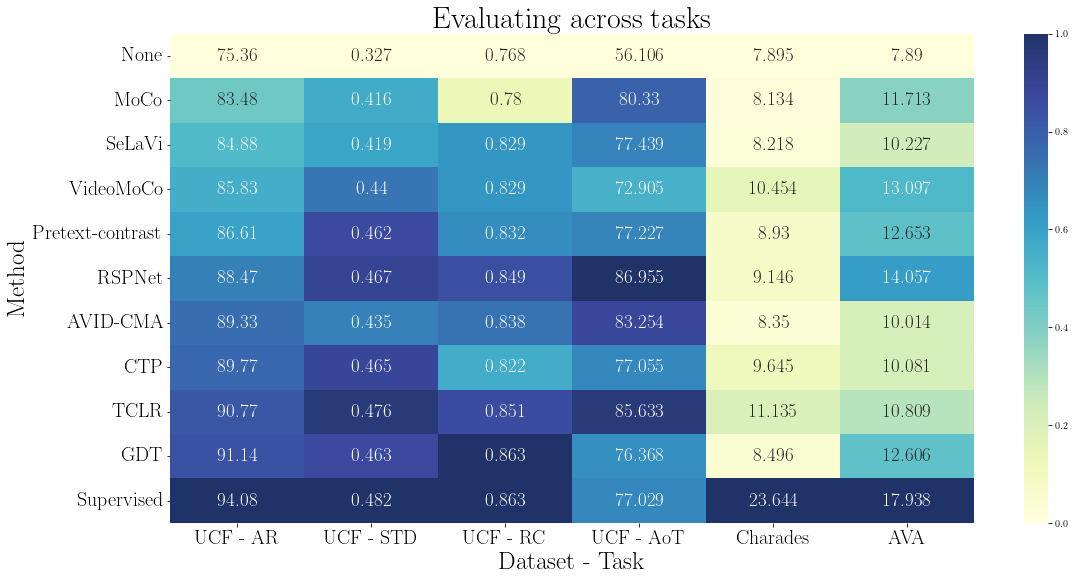

In [76]:
plot_heatmap(
    norm_df,
    figsize=(18, 9),
    title="Evaluating across tasks",
    titlesize=30,
    labelsize=25,
    tickssize=20,
    save=True,
    save_path="../../results/plots/heatmap_task_shift_v3.pdf",
    cmap="YlGnBu",
    alpha=0.9,
    annot=np.round(df_task.values, 3),
    fmt='g',
    annot_kws={"size": 19},
    xlabel="Dataset - Task",
    ylabel="Method",
    xrotation=0,
    # vmin=-2.,
    # vmax=2.,
)

In [58]:
df = df_task.copy()
corr = df_task.corr("spearman").loc["UCF - AR"]

In [59]:
corr

UCF - AR     1.000000
UCF - STD    0.845455
UCF - RC     0.772727
UCF - AoT    0.390909
Charades     0.618182
AVA          0.254545
Name: UCF - AR, dtype: float64

### Domain-shift: Linear and Finetuning

In [5]:
from utils_local import load_domain_shift_results, scatter_with_correlation

In [6]:
k400_values, df_linear, df_finetune = load_domain_shift_results(remove_K400=True)
ucf101_values = {"Method": list(df_finetune.index), "finetune": df_finetune["UCF101"].values}

In [7]:
k400_values['Method'], k400_values['linear']

(['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ]))

In [8]:
ucf101_values

{'Method': ['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 'finetune': array([75.36, 83.8 , 84.88, 85.83, 86.6 , 88.47, 89.33, 89.77, 90.77,
        91.14, 94.08])}

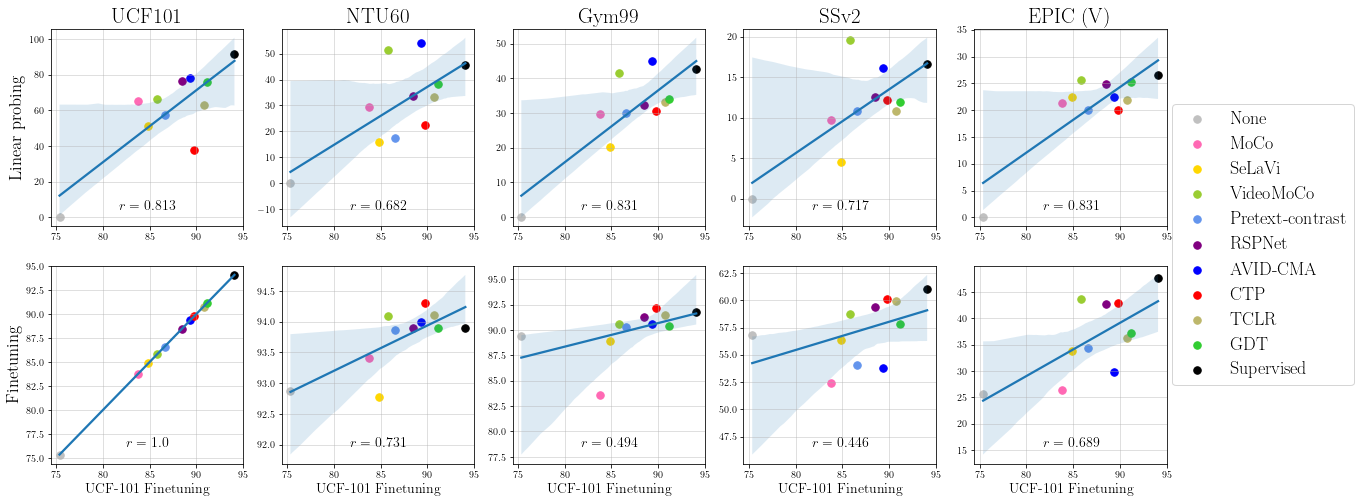

In [9]:
nrows, ncols = 2,  len(df_linear.columns)
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8))

# xaxis = "K400"
xaxis = "UCF101"
if xaxis == "K400":
    xvalues = k400_values["linear"]
    xlabel = "K400 Linear"
elif xaxis == "UCF101":
    xvalues = ucf101_values["finetune"]
    xlabel = "UCF-101 Finetuning"
else:
    raise ValueError

# plot correlations for linear probing
for i in range(ncols):
    ax = axes[0][i]

    dataset = df_linear.columns[i]

    ylabel = "Linear probing" if i == 0 else ""
    legend=False
    legend_kwargs=dict(fontsize=20)

    scatter_with_correlation(
        xvalues=xvalues,
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        titlesize=30,
        xlabel="",
        ylabel=ylabel,
        ylabelsize=24,
        legend=legend,
        legend_kwargs=legend_kwargs,
        add_corr_to_title=False,
        add_corr_to_text=True,
    )
    # ax.grid()
    ax.grid(alpha=0.5)

# plot correlations for finetuning
for i in range(ncols):
    ax = axes[1][i]

    dataset = df_finetune.columns[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == ncols - 1 else False
    legend_kwargs = dict(
        ncol=1,
        loc='lower center',
        bbox_to_anchor=(1.5, 0.35),
        fontsize=18,
    )

    scatter_with_correlation(
        xvalues=xvalues,
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title="",
        xlabel=xlabel,
        ylabel=ylabel,
        ylabelsize=24,
        legend=legend,
        legend_kwargs=legend_kwargs,
        add_corr_to_title=False,
        add_corr_to_text=True,
    )
    
    ax.grid(alpha=0.5)

# plt.suptitle("Correlation of linear probing w.r.t. K400 Linear", fontsize=22, y=1.0)
plt.savefig(f"../../results/plots/correlations_domain_shift_on_{xaxis}.pdf", bbox_inches="tight")
plt.show()

### Individual

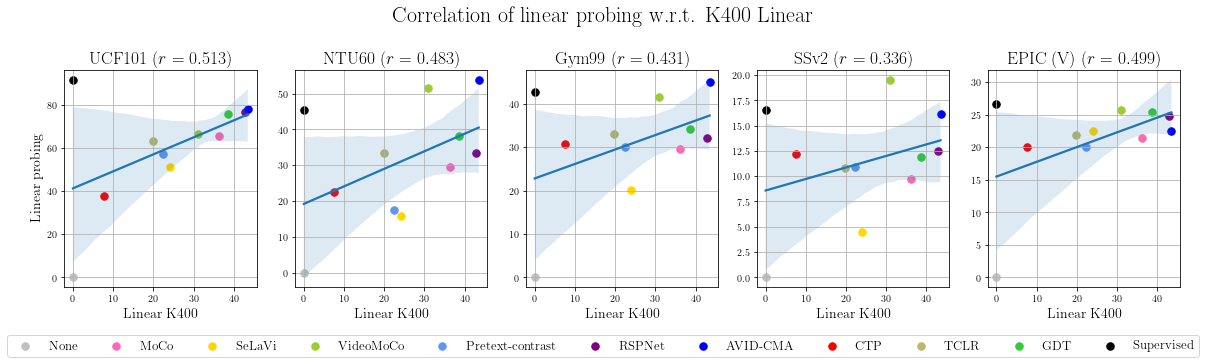

In [10]:
fig, axes = plt.subplots(1, len(df_linear.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_linear.columns[i]
    
    ylabel = "Linear probing" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of linear probing w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

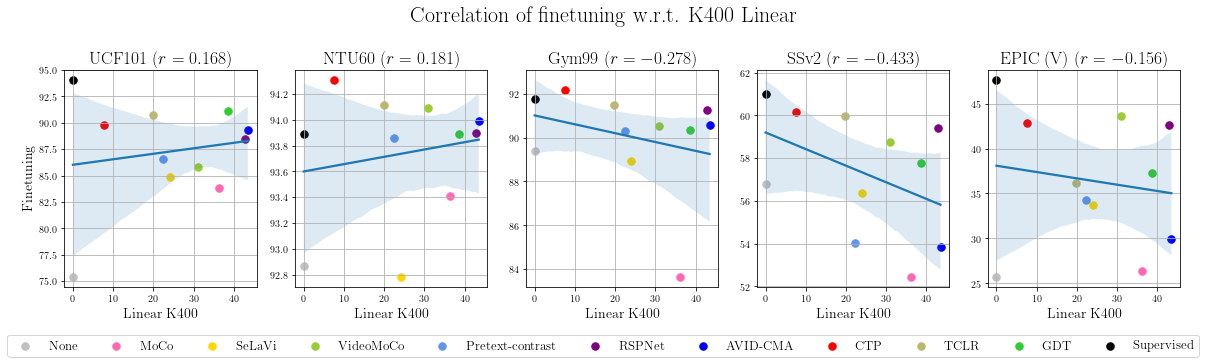

In [11]:
fig, axes = plt.subplots(1, len(df_finetune.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

#### Correlation with UCF performance

In [12]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
MoCo,83.80,93.41,83.62,52.42,26.40
SeLaVi,84.88,92.78,88.93,56.37,33.77
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
RSPNet,88.47,93.90,91.28,59.39,42.67
AVID-CMA,89.33,93.99,90.56,53.82,29.91
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.97,36.18
GDT,91.14,93.89,90.36,57.78,37.26


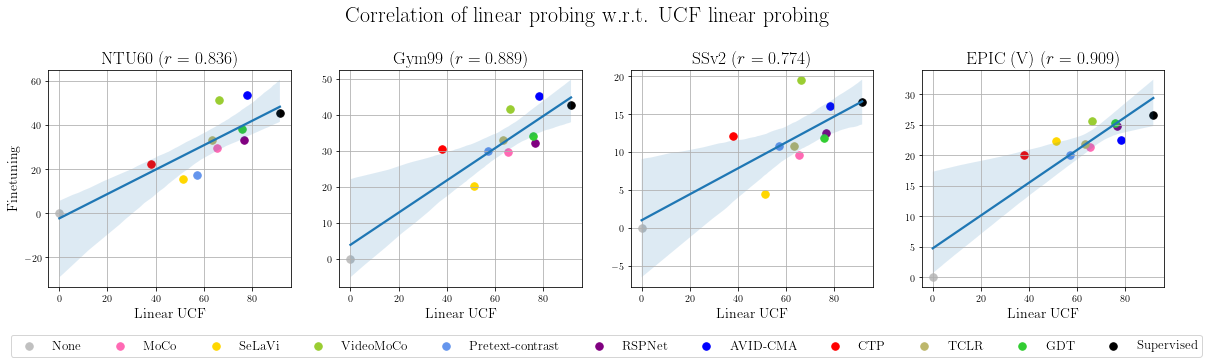

In [13]:
datasets = [x for x in df_linear.columns if "UCF" not in x]

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-1.3, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_linear["UCF101"].values,
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear UCF",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of linear probing w.r.t. UCF linear probing", fontsize=22, y=1.1)
plt.show()

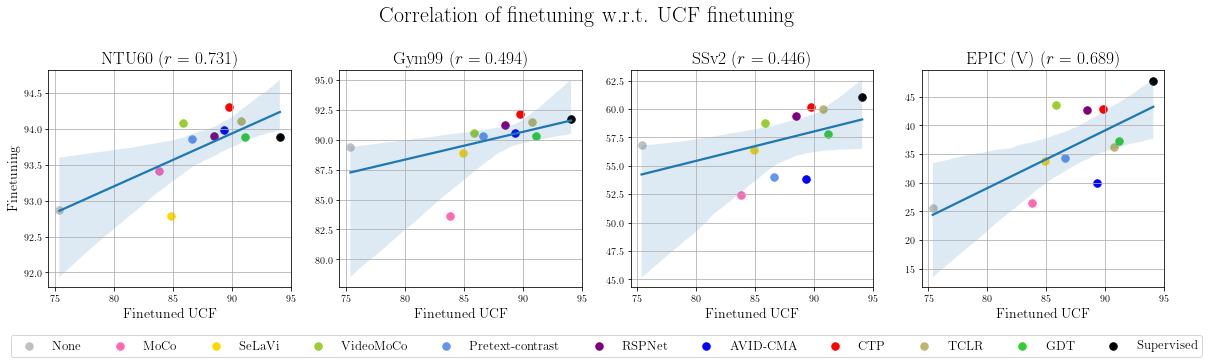

In [14]:
datasets = [x for x in df_linear.columns if "UCF" not in x]

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_finetune.index),
        loc='lower center',
        bbox_to_anchor=(-1.3, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_finetune["UCF101"].values,
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Finetuned UCF",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of finetuning w.r.t. UCF finetuning", fontsize=22, y=1.1)
plt.show()

### Domain-shift with varying training data size

In [53]:
df = read_spreadsheet(gid_key="dataset_size")
df.dropna(inplace=True)

In [54]:
dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

In [55]:
for d, v in dataset_full_size.items():
    indices = (df.Dataset == d) * (df["Dataset size"] == "Full")
    df.at[indices, "Dataset size (float)"] = v

In [56]:
df["Dataset size (float)"] = df["Dataset size (float)"].astype(float)

In [57]:
df_ucf = apply_filters(df, {"Dataset": "UCF"})

In [58]:
k400_values

{'Method': ['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 'linear': array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ])}

In [59]:
ucf101_values

{'Method': ['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 'finetune': array([75.36, 83.8 , 84.88, 85.83, 86.6 , 88.47, 89.33, 89.77, 90.77,
        91.14, 94.08])}

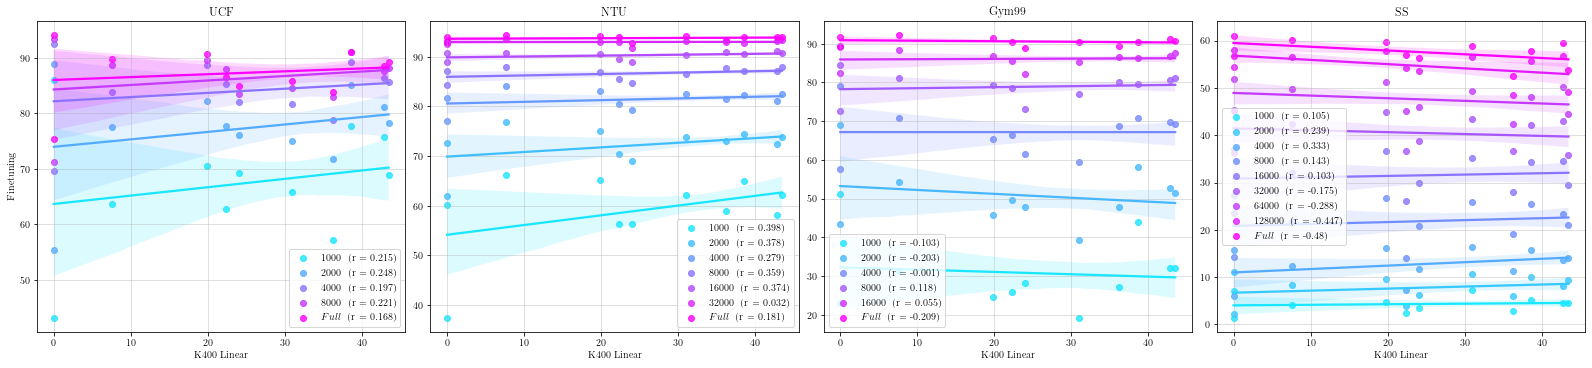

In [60]:
import matplotlib
cmap = matplotlib.cm.get_cmap('cool')

xaxis = "K400"
# xaxis = "UCF101"
if xaxis == "K400":
    xvalues = k400_values["linear"]
    xmethods = k400_values["Method"]
    xlabel = "K400 Linear"
elif xaxis == "UCF101":
    xvalues = ucf101_values["finetune"]
    xmethods = ucf101_values["Method"]
    xlabel = "UCF-101 Finetuning"
else:
    raise ValueError

ylabel = "Finetuning"
datasets = df.Dataset.unique()


fig, axes = plt.subplots(1, len(datasets), figsize=(22, 5), constrained_layout=True)

for i, dataset in enumerate(datasets):

    ax = axes[i]
    dataset = datasets[i]
    ax.set_title(dataset)
    ax.set_xlabel(xlabel)
    
    if i == 0:
        ax.set_ylabel(ylabel)

    ax.grid(alpha=0.5)
    
    df_dataset = apply_filters(df, {"Dataset": dataset})
    sizes = df_dataset["Dataset size"].unique()
    colors = [cmap(x) for x in np.linspace(0.1, 1, len(sizes))]

    # draw correlation lines for each dataset size
    for j, size in enumerate(sizes):
        sdf = apply_filters(df_dataset, {"Dataset size": size})

        # reorder based on xmethods performance
        sdf = sdf.set_index("Method").rename(index={
            "No pretraining": "None",
            "Supervised pretraining": "Supervised",
            "SELAVI": "SeLaVi",
            "RSPNET": "RSPNet",
            "Video Moco": "VideoMoCo",
            "Pretext-Contrast": "Pretext-contrast",
        }).loc[np.array(xmethods)].reset_index()

        yvalues = sdf["Top-1"].values

        corr_val = np.round(np.corrcoef(xvalues, yvalues)[0, 1], decimals=3)
        corr = f"$r = {corr_val}$"
        label = "${} \ \ ({})$".format(size, corr)
        sns.regplot(x=xvalues, y=yvalues, ax=ax, scatter=True, ci=80, label=label, color=colors[j])

    ax.legend()

plt.show()

In [61]:
from scipy.stats import spearmanr

In [62]:
pearson_correlations = dict()
spearman_rank_correlations = dict()

xaxis = "K400"
# xaxis = "UCF101"
if xaxis == "K400":
    xvalues = k400_values["linear"]
    xmethods = k400_values["Method"]
    xlabel = "K400 Linear"
elif xaxis == "UCF101":
    xvalues = ucf101_values["finetune"]
    xmethods = ucf101_values["Method"]
    xlabel = "UCF-101 Finetuning"
else:
    raise ValueError

datasets = df.Dataset.unique()

for i, dataset in enumerate(datasets):

    dataset = datasets[i]
    df_dataset = apply_filters(df, {"Dataset": dataset})

    sizes = df_dataset["Dataset size"].unique()
    p_corrs = []
    s_corrs = []

    # draw correlation lines for each dataset size
    for j, size in enumerate(sizes):
        sdf = apply_filters(df_dataset, {"Dataset size": size})

        # reorder based on xmethods performance
        sdf = sdf.set_index("Method").rename(index={
            "No pretraining": "None",
            "Supervised pretraining": "Supervised",
            "SELAVI": "SeLaVi",
            "RSPNET": "RSPNet",
            "Video Moco": "VideoMoCo",
            "Pretext-Contrast": "Pretext-contrast",
        }).loc[np.array(xmethods)].reset_index()

        yvalues = sdf["Top-1"].values

        p_corr = np.round(np.corrcoef(xvalues, yvalues)[0, 1], decimals=3)
        p_corrs.append(p_corr)
        
        s_corr = spearmanr(xvalues, yvalues).correlation
        s_corrs.append(s_corr)
    
    pearson_correlations[dataset] = {"size": sizes, "corr": p_corrs}
    spearman_rank_correlations[dataset] = {"size": sizes, "corr": s_corrs}

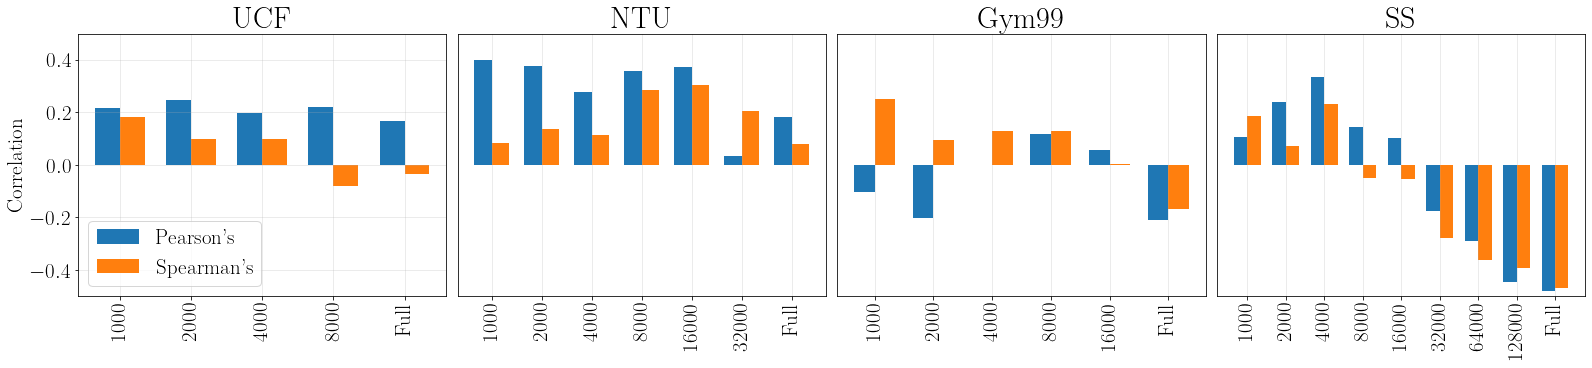

In [90]:
fig, axes = plt.subplots(1, len(datasets), figsize=(22, 5), constrained_layout=True)

width = 0.35
titlesize = 30
tickssize = 21
labelsize = 21
ylabelsize = 21
ylim = (-0.5, 0.5)

for i, dataset in enumerate(datasets):
    ax = axes[i]

    ax.set_title(dataset, fontsize=titlesize)
    ax.grid(alpha=0.5, axis="y")

    x_ticklabels = pearson_correlations[dataset]["size"]
    x = np.arange(0, len(x_ticklabels))
    ax.bar(x=x, height=pearson_correlations[dataset]["corr"], width=width, label="Pearson's")
    ax.bar(x=x + width, height=spearman_rank_correlations[dataset]["corr"], width=width, label="Spearman's")

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(x_ticklabels)
    if i == 0:
        ax.set_ylabel("Correlation", fontsize=ylabelsize)
        ax.legend(fontsize=labelsize)
    else:
        ax.set_yticks([])
    
    ax.tick_params(axis='y', which='major', labelsize=tickssize, rotation=0)
    ax.tick_params(axis='x', which='major', labelsize=tickssize, rotation=90)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.3)

plt.savefig(f"../../results/plots/both_correlations_on_{xlabel}_dataset_size_v1.pdf", bbox_inches="tight")
plt.show()

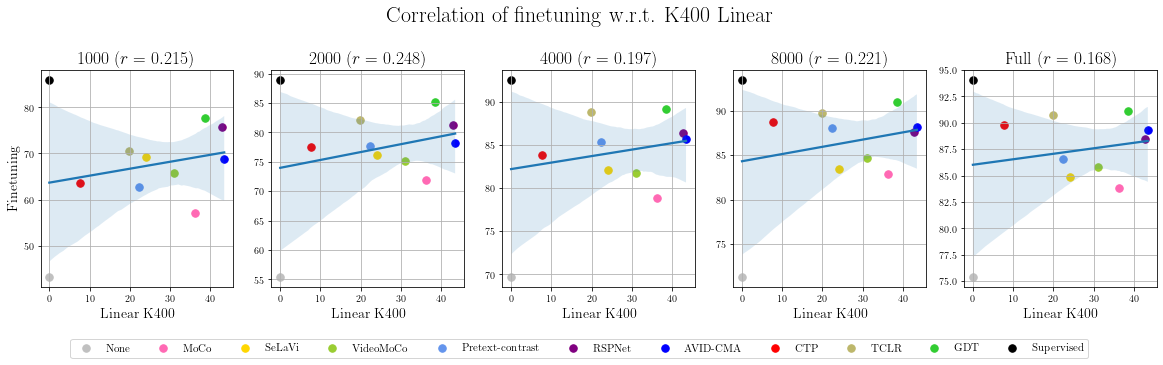

In [26]:
sizes = df_ucf["Dataset size"].unique()

fig, axes = plt.subplots(1, len(sizes), figsize=(20, 4))


for i, size in enumerate(sizes):
    sdf = apply_filters(df_ucf, {"Dataset size": size})

    # reorder based on UCF finetuning performance
    sdf = sdf.set_index("Method").rename(index={
        "No pretraining": "None",
        "Supervised pretraining": "Supervised",
        "SELAVI": "SeLaVi",
        "RSPNET": "RSPNet",
        "Video Moco": "VideoMoCo",
        "Pretext-Contrast": "Pretext-contrast",
    }).loc[np.array(k400_values["Method"])].reset_index()

    methods = sdf.Method.values

    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(methods),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=11,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=sdf["Top-1"].values,
        labels=methods,
        ax=ax,
        size_alpha=0.7,
        title=size,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()


plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

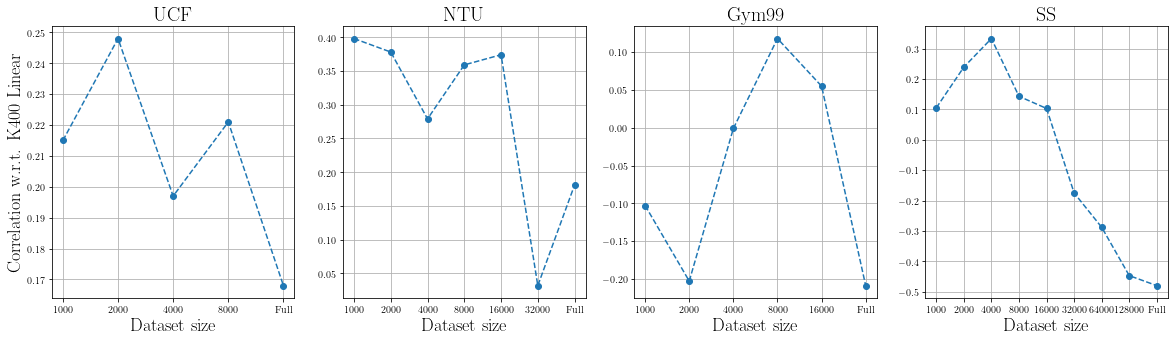

In [27]:
datasets = df.Dataset.unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5))


ax.grid()
ax.set_title("Correlation between K400 linear vs finetuning", fontsize=20)


for i, dataset in enumerate(datasets):
    
    ax = axes[i]

    sizes_to_plot = []
    correlations = []
    
    df_dataset = apply_filters(df, {"Dataset": dataset})
    sizes = df_dataset["Dataset size"].unique()


    xvalues = k400_values["linear"]
    for j, size in enumerate(sizes):
        sdf = apply_filters(df_dataset, {"Dataset size": size})
        # reorder based on UCF finetuning performance
        sdf = sdf.set_index("Method").rename(index={
            "No pretraining": "None",
            "Supervised pretraining": "Supervised",
            "SELAVI": "SeLaVi",
            "RSPNET": "RSPNet",
            "Video Moco": "VideoMoCo",
            "Pretext-Contrast": "Pretext-contrast",
        }).loc[np.array(k400_values["Method"])].reset_index()
        

        methods = sdf.Method.values

        yvalues = sdf["Top-1"].values

        corr = np.round(np.corrcoef(xvalues, yvalues)[0, 1], decimals=3)
        # corr = stats.spearmanr(xvalues, yvalues).correlation
        sizes_to_plot.append(size)
        correlations.append(corr)
    
    # ax.set_ylim(-0.5, 0.6)
    ax.plot(sizes_to_plot, correlations, "--o", label=dataset)
    ax.set_title(dataset, fontsize=20)
    ax.grid()
    ax.set_xlabel("Dataset size", fontsize=18)

    if i == 0:
        ax.set_ylabel("Correlation w.r.t. K400 Linear", fontsize=18)

plt.show()

### Correlation plots for `FineGym`

In [28]:
from utils_local import load_finegym_results

In [29]:
df = load_finegym_results()

In [30]:
df

,Method,Gym99 (99) (video),Gym99 (99) (class),Gym288 (288) (video),Gym288 (288) (class),Vault (6) (video),Vault (6) (class),FX (35) (video),FX (35) (class),FX-S1 (11) (video),FX-S1 (11) (class),UB-S1 (15) (video),UB-S1 (15) (class)
0,None,89.41,84.40,84.71,50.01,41.26,24.67,79.16,75.88,50.32,44.98,88.44,83.98
1,MoCo,89.41,83.62,85.05,51.65,43.95,32.10,85.76,82.95,70.27,62.21,88.85,84.14
2,SeLaVi,88.93,84.75,83.68,52.82,43.72,25.44,80.01,76.04,57.92,50.15,85.11,81.46
3,VideoMoCo,90.54,86.36,85.31,54.07,45.74,27.78,84.19,79.52,68.60,60.39,87.90,82.07
4,Pretext-contrast,90.31,85.70,85.42,52.66,46.19,28.48,84.68,81.37,72.84,65.78,90.62,86.24
5,RSPNet,91.28,87.59,86.11,55.20,43.72,33.35,85.40,82.72,71.30,63.50,89.06,85.12
6,AVID-CMA,90.56,85.83,85.96,52.46,45.52,30.35,85.98,82.65,75.29,67.15,92.45,88.41
7,CTP,92.17,88.33,87.33,56.51,44.17,26.83,88.99,86.16,84.68,79.66,92.32,88.44
8,TCLR,91.49,87.97,86.93,55.37,46.19,29.84,87.38,84.25,69.63,61.02,90.48,85.29
9,GDT,90.36,86.46,85.74,55.36,44.62,33.11,85.80,83.64,72.84,65.72,88.17,81.62


In [31]:
# extract per-class results
df_class = df[[x for x in df.columns if "class" in x or "Method" in x]]
df_class = df_class.set_index(keys=["Method"])
df_class.columns = [x.replace(" (class)", "") for x in df_class.columns]

In [32]:
df_class

,Gym99 (99),Gym288 (288),Vault (6),FX (35),FX-S1 (11),UB-S1 (15)
Method,,,,,,
None,84.40,50.01,24.67,75.88,44.98,83.98
MoCo,83.62,51.65,32.10,82.95,62.21,84.14
SeLaVi,84.75,52.82,25.44,76.04,50.15,81.46
VideoMoCo,86.36,54.07,27.78,79.52,60.39,82.07
Pretext-contrast,85.70,52.66,28.48,81.37,65.78,86.24
RSPNet,87.59,55.20,33.35,82.72,63.50,85.12
AVID-CMA,85.83,52.46,30.35,82.65,67.15,88.41
CTP,88.33,56.51,26.83,86.16,79.66,88.44
TCLR,87.97,55.37,29.84,84.25,61.02,85.29


In [33]:
datasets

array(['UCF', 'NTU', 'Gym99', 'SS'], dtype=object)

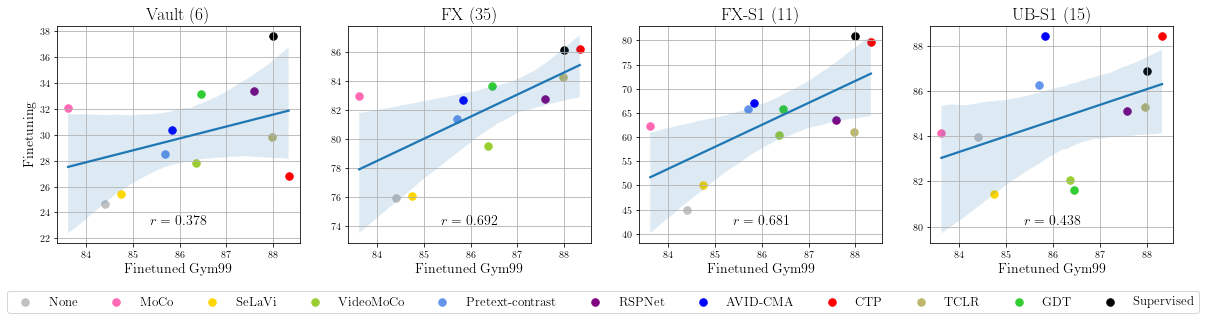

In [34]:
datasets = [x for x in df_class.columns if not ("Gym99" in x)]
datasets = [x for x in df_class.columns if not ("Gym99" in x or "Gym288" in x)]
legend_xloc = -2.0 if len(datasets) == 5 else -1.35

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_class.index),
        loc='lower center',
        bbox_to_anchor=(legend_xloc, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_class["Gym99 (99)"].values,
        yvalues=df_class[dataset].values,
        labels=df_class.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Finetuned Gym99",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
        add_corr_to_text=True,
        add_corr_to_title=False,
    )
    ax.grid()

# plt.suptitle("Correlation of FineGym subsets w.r.t. Gym-99 (per-class)", fontsize=22, y=1.1)
plt.show()

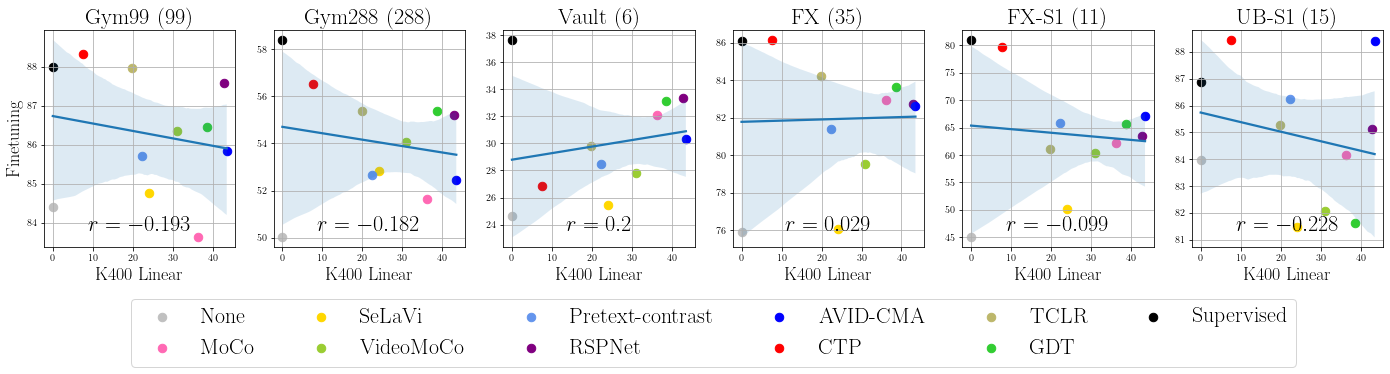

In [36]:
key = "K400-linear"
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key=key)

datasets = [x for x in df_class.columns]
df = df_class.loc[np.array(xmethods)].reset_index()

fig, axes = plt.subplots(1, len(datasets), figsize=(24, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df.index) // 2 + 1,
        loc='lower center',
        bbox_to_anchor=(-2.5, -0.6),
        fontsize=22,
    )
    
    scatter_with_correlation(
        xvalues=xvalues,
        yvalues=df[dataset].values,
        labels=xmethods,
        ax=ax,
        size_alpha=0.9,
        title=dataset,
        xlabel=xlabel,
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
        add_corr_to_text=True,
        add_corr_to_title=False,
        legendsize=25,
    )
    ax.grid()

# plt.suptitle("Correlation of FineGym subsets w.r.t. Gym-99 (per-class)", fontsize=22, y=1.1)
plt.savefig(f"../../results/plots/correlations_action_granularity_on_{key}.pdf", bbox_inches="tight")
plt.show()

### Task shift

In [37]:
df = read_spreadsheet(gid_key="task_shift_ucf")

# consider complement on Repetition
complement_repetition = True
if complement_repetition:
    df["UCF - Repetition (MAE)"] = 1 - df["UCF - Repetition (MAE)"]
    # df["Repetition (1 - MAE)"] = df["Repetition (MAE)"]
    df.rename(columns={"UCF - Repetition (MAE)": "UCF - Repetition (1 - MAE)"}, inplace=True)

# order by Action recognition
df.sort_values("UCF - Action recognition (Top-1)", inplace=True)

# reorder tasks
correct_order = [
    "Method",
    "UCF - Action recognition (Top-1)",
    "UCF - Spatio-temporal (IoU@0.5)",
    "UCF - Repetition (1 - MAE)",
    "UCF - AoT (Top-1)",
    "Charades - Multi-label classification (mAP)",
]
df = df[correct_order]

# set index
df.set_index("Method", inplace=True)

In [38]:
df

,UCF - Action recognition (Top-1),UCF - Spatio-temporal (IoU@0.5),UCF - Repetition (1 - MAE),UCF - AoT (Top-1),Charades - Multi-label classification (mAP)
Method,,,,,
None,75.36,0.3273,0.7680,56.106,7.895
VideoMoco,85.59,0.4374,0.8241,72.905,10.454
Pretext-contrast,85.83,0.4619,0.8315,77.227,8.930
SeLaVi,86.60,0.4192,0.8488,77.439,8.218
RSPNet,88.47,0.4401,0.8400,86.955,9.146
AVID-CMA,89.33,0.4354,0.8381,83.254,8.350
TCLR,89.77,0.4764,0.8507,85.633,11.135
CTP,90.77,0.4646,0.8217,77.055,9.645
GDT,91.14,0.4629,0.8633,76.368,8.496


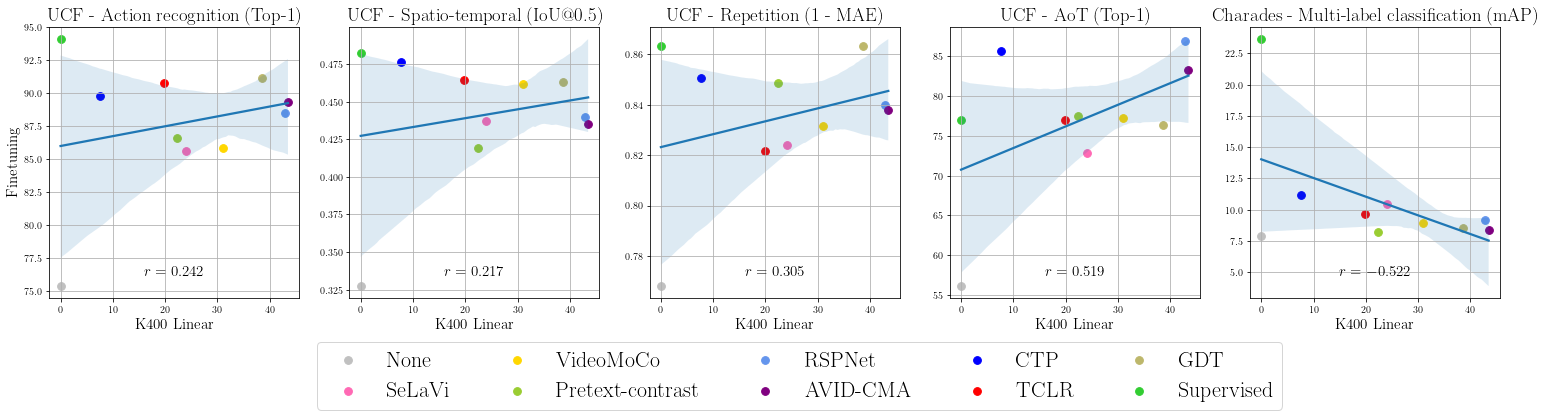

In [58]:
key = "K400-linear"
xmethods, xvalues, xlabel = get_xvalues_for_correlation(key=key)

remove_moco = True
if remove_moco:
    xvalues = list(xvalues)
    if "MoCo" in xmethods:
        moco_index = xmethods.index("MoCo")
        xmethods = [x for i, x in enumerate(xmethods) if i != moco_index]
        xvalues = [x for i, x in enumerate(xvalues) if i != moco_index]

tasks = df.columns
colors = {
    "UCF": None,
    "Charades": None,
}

fig, axes = plt.subplots(1, len(tasks), figsize=(26, 5))

for i in range(len(axes)):
    ax = axes[i]
    
    task = tasks[i]
    dataset = task.split(" - ")[0]
    color = colors[dataset]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(xmethods) // 2,
        loc='lower center',
        bbox_to_anchor=(-1.8, -0.45),
        fontsize=22,
    )
    
    scatter_with_correlation(
        xvalues=xvalues,
        yvalues=df[task].values,
        labels=xmethods,
        ax=ax,
        size_alpha=0.75,
        title=task,
        xlabel=xlabel,
        ylabel=ylabel,
        legend=legend,
        regcolor=color,
        legend_kwargs=legend_kwargs,
        add_corr_to_text=True,
        add_corr_to_title=False,
    )
    ax.grid()

# plt.suptitle("Correlation of various tasks w.r.t. Action recognition on UCF-101", fontsize=22, y=1.05)
plt.savefig(f"../../results/plots/correlations_task_shift_on_{key}.pdf", bbox_inches="tight")
plt.show()

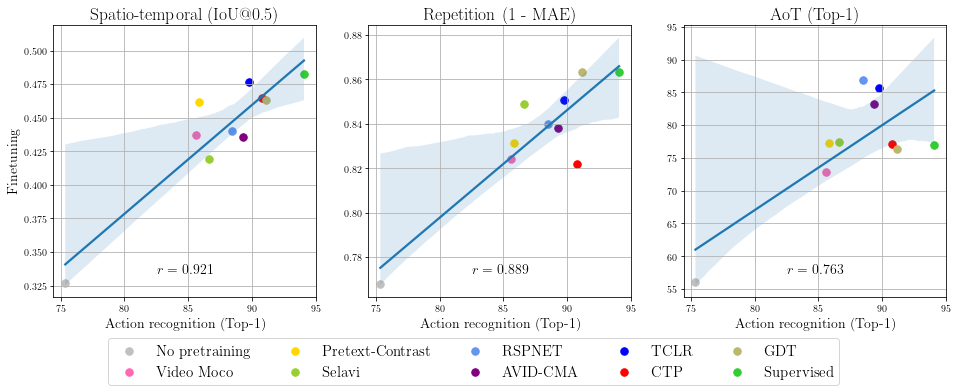

In [296]:
tasks = [x for x in df.columns if not ("Action recognition" in x)]
# legend_xloc = -2.0 if len(datasets) == 5 else -1.35
legend_xloc = -0.8

fig, axes = plt.subplots(1, len(tasks), figsize=(16, 5))

for i in range(len(axes)):
    ax = axes[i]
    
    task = tasks[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df.index) // 2,
        loc='lower center',
        bbox_to_anchor=(legend_xloc, -0.35),
        fontsize=15,
    )
    
    scatter_with_correlation(
        xvalues=df["Action recognition (Top-1)"].values,
        yvalues=df[task].values,
        labels=df.index,
        ax=ax,
        size_alpha=0.7,
        title=task,
        xlabel="Action recognition (Top-1)",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
        add_corr_to_text=True,
        add_corr_to_title=False,
    )
    ax.grid()

# plt.suptitle("Correlation of various tasks w.r.t. Action recognition on UCF-101", fontsize=22, y=1.05)
plt.show()